# Dostrajanie wstępnie wytrenowanego modelu BERT - Wykład

Niniejszy notatnik omawia wykorzystanie i dostrajanie **wstępnie wytrenowanego modelu językowego** DistilBERT ([link](https://huggingface.co/docs/transformers/model_doc/distilbert)).
DistilBERT jest relatywnie niewielkim i szybkim modelem klasy tylko-koder z dwukierunkową atencją powstałym poprzez destylację wiedzy metodą nauczyciel-uczeń z modelu BERT. Opis metody destylacji wiedzy: [link](https://medium.com/huggingface/distilbert-8cf3380435b5).

Wstępnie wytrenowany model DistilBERT zostanie dostrojony (*fine-tuning*) do zadania klasyfikacji tekstu. Wykorzystamy zbiór danych [Yelp Review](https://pytorch.org/text/stable/datasets.html#yelpreviewfull), gdzie opinii w języku naturalnym towarzyszy ocena w skali od jednej do pięciu gwiazdek. Zadaniem jest estymacja oceny wystawionej przez klienta (liczba gwiazdek) na podstawie opinii w języku naturalnym.

#1. Przygotowanie środowiska

Import funkcji i klas wykorzystywanych w dalszej części notatnika.

In [1]:
import numpy as np
import math
import os
import random
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.utils.data import dataset

%matplotlib inline

Sprawdzenie, czy notatnik jest uruchomiony na instancji z GPU. Sprawdzenie typu i parametrów procesora graficznego.

In [2]:
!nvidia-smi

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Urządzenie: {device}')

Sun Apr 13 12:45:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Wykorzystamy blibiotekę Hugging Face Transformers ([link](https://huggingface.co/docs/transformers/index)). Biblioteka zawiera wiele pre-trenowanych modeli językowych opartych o architekturę Transformers oraz narzędzia pozwalające na przystosowanie i dostrajanie tych modeli do zadań z zakresu przetwarzania języka naturalnego.

In [3]:
!pip install -q datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.

In [4]:
import transformers

print(f"PyTorch: {torch.__version__}")
print(f"HuggingFace Transformers: {transformers.__version__}")

PyTorch: 2.6.0+cu124
HuggingFace Transformers: 4.50.3


#2. Przygotowanie danych

Pobranie zbioru danych [Yelp Review](https://pytorch.org/text/stable/datasets.html#yelpreviewfull). Z uwagi na duży rozmiar zbioru Yelp Review (prawie 2 GB) w tym notatniku wykorzystamy mały podzbiór pełnego zbioru danych (yelp_review_small).

In [5]:
from datasets import load_dataset

train_dataset = load_dataset("yelp_review_full", split="train[:5%]")
test_dataset = load_dataset("yelp_review_full", split="test[:5%]")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.72k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
print(train_dataset)
print(test_dataset)

Dataset({
    features: ['label', 'text'],
    num_rows: 32500
})
Dataset({
    features: ['label', 'text'],
    num_rows: 2500
})


Bibioteka HuggingFace domyślnie zakłada, że zbiory danych wykorzystywane w zadaniu klasyfikacji tekstu zawierają etykiety klas są w koumnie `labels` a dane wejściowe (tekst w języku naturalnym) w kolumnie `text`.

Wyświetl przykładowy element ze zbioru treningowego. Wyświetl liczbę elementów z każdej klasy w zbiorze treningowym i testowym.

In [7]:
from collections import Counter

print(train_dataset[0])
labels = [e['label'] for e in train_dataset]
print(labels[:20])
print()
print(f"Liczność klas w zbiorze treningowym: {Counter(labels)}")
print(f"Liczność klas w zbiorze testowym: {Counter(labels)}")

{'label': 4, 'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."}
[4, 1, 3, 3, 0, 4, 4, 0, 1, 2, 0, 0, 3, 1, 4, 4, 4, 4, 4, 4]

Liczność klas w zbiorze treningowym: Counter({2: 6730, 1: 6718, 0: 6633, 3: 6523, 4: 5896})
Liczność klas w zbiorze testowym: Counter({2: 6730, 1: 6718, 0: 6633, 3: 6523, 4: 5896})


Etykiety klas zawierają się między 0 a 4 (0=najniższa ocena, 1=najwyższa ocena).
W ogólności, etykiety klas muszą być w przedziale *0..N-1*, gdzie *N* jest liczbą klas.



Zdefiniuj **tokenizer**, który zamieni tekst w języku naturalnym na ciąg tokenów. Metoda BERT korzysta z algorytmu tokenizacji WordPiece, opartego o części słów.

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [9]:
token_ids = tokenizer.encode("This is a tokenizer test")
print(f"Identyfikatory tokenów: {token_ids}")
tokens = tokenizer.convert_ids_to_tokens(token_ids)
print(f"Tokeny: {tokens}")

Identyfikatory tokenów: [101, 2023, 2003, 1037, 19204, 17629, 3231, 102]
Tokeny: ['[CLS]', 'this', 'is', 'a', 'token', '##izer', 'test', '[SEP]']


Zwróćmy uwagę, że tokenizer domyślnie dołącza na początku sekwencji specjalny token `[CLS]`. Jet to typowe dla tokenizatorów wykorzystywanych przez modele klasy tylko-koder, np. z rodziny BERT.
Kontekstowa reprezentacja tokenu `[CLS]`, czyli pierwszy wektor w sekwencji wyjściowej z kodera Transformer, jest wykorzystywana jako wektor cech charakteryzujący całą sekwencję wejściową.

Wykonaj tokenizację zbioru danych.

In [10]:
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

print(tokenized_train_dataset)
print(tokenized_test_dataset)

Map:   0%|          | 0/32500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 32500
})
Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 2500
})


**ZADANIE**

Wyświel kilka losowych elementów zbioru danych `tokenized_train_dataset['train']` po tokenizacji. Dla każdego elementu zbioru danych wyświetl następujące wartości:

*   identyfikator klasy (liczba gwiazdek nadana przez użytkownika minus jeden)
*   originalny tekst
*   tekst po tokenizacji i zamianie tokenów na numberyczne identyfikatory
*   listę tokenów (tekstowych tokenów a nie ich numerycznych identyfikatorów)



In [11]:
for i in range(5):
  ndx = random.randrange(len(tokenized_train_dataset))
  e = tokenized_train_dataset[ndx]
  print(e['label'])
  print(e['text'])
  print(e['input_ids'])
  tokens = tokenizer.convert_ids_to_tokens(e['input_ids'])
  print(tokens)

4
Gave LGO another shot and they have forever won back our business. Our servers name was Lindsey and she made our night a perfect experience. Thank you LGO for making it right!
[101, 2435, 1048, 3995, 2178, 2915, 1998, 2027, 2031, 5091, 2180, 2067, 2256, 2449, 1012, 2256, 14903, 2171, 2001, 17518, 1998, 2016, 2081, 2256, 2305, 1037, 3819, 3325, 1012, 4067, 2017, 1048, 3995, 2005, 2437, 2009, 2157, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

#3. Dostrajanie pre-trenowanego modelu BERT

Utwórz model do klasyfikacji zdań języka naturalnego oparty o pre-trenowany model DistilBERT. Wykorzystamy model `AutoModelForSequenceClassification` w którym do podstawowego modelu językowego (w naszym przypadku DistikBERT) została **dodana głowica klasyfikacyjna**, predykująca klasę wejściowej sekwencji. Parametr `num_labels` określa liczbę klas w głowicy klasyfikatora.

In [12]:
from transformers import AutoModelForSequenceClassification

#model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)
#from transformers import DistilBertModel
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [14]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer", eval_strategy="steps", report_to="none",
                                  per_device_eval_batch_size=32, per_device_train_batch_size=32,
                                  logging_steps=200, fp16=True, num_train_epochs=2)
print(training_args)

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=200,
eval_strategy=IntervalStrategy.STEPS,
eval_u

Komunikaty o błędach wyświetlone podczas ładowania pre-trenowanego modelu możemy zignorować. Są spowodowane tym, że z bazowego modelu BERT usuwane są warstwy wykorzystywane przy trenowaniu modelu BERT i dodawana jest warstwa klasyfikatora z zainicjalizowanymi losowo wagami. Utworzony model musimy dostroić (*fine-tuning*) aby był użyteczny.

`compute_metrics` jest pomocniczą funkcją obliczającą dokładność klasyfikacji.

In [15]:
import numpy as np
from evaluate import load

metric = load("accuracy")

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)


Do dostrojenia modelu wykorzystamy klasę `Trainer` dostępną w bibliotece Hugging Face. Automatyzuje ona cały proces dostrojania modelu.

Zanim zdefiniujemy klasę `Trainer`, musimy zdefiniować parametry procesu trenowania. Klasa `TrainingArguments` definiuje wszystkie parametry procesu uczenia. Szczegółowy opis argumentów treningowych `TrainingArguments` jest [tutaj](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments)

Klasa `Trainer` automatyzuje proces trenowania modelu. Szczegółowy opis jest dostępny tutaj: [link](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer)

In [16]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
)

Rozpocznij dostrajanie modelu. Model dostraja się przez dwie epoki co zajmuje około 10 minut na T4 GPU.

In [17]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
200,1.147700,0.993259,0.557600
400,0.958400,0.984344,0.560400
600,0.923000,0.915625,0.596800
800,0.906100,0.905409,0.594000
1000,0.875500,0.908716,0.606000
1200,0.749500,0.894658,0.615600
1400,0.715500,0.905089,0.610400
1600,0.707400,0.863362,0.629200
1800,0.704500,0.876166,0.633600
2000,0.697600,0.868102,0.634800


TrainOutput(global_step=2032, training_loss=0.8361169606681884, metrics={'train_runtime': 955.3389, 'train_samples_per_second': 68.039, 'train_steps_per_second': 2.127, 'total_flos': 8610841574400000.0, 'train_loss': 0.8361169606681884, 'epoch': 2.0})

#4. Wykorzystanie dostrojonego modelu

Sprawdzenie działania dostrojonego modelu na zbiorze testowym. Dla każego elementu zbioru testowego wykonaj predykcję oceny (liczby gwiazdek) na podstawie opinii. Identyfikator predykowanej klasy odpowiada oceniue przyznanej przez klienta (liczba gwiazdek) minus jeden.

In [18]:
predictions = trainer.predict(tokenized_test_dataset)
# predictions jest tensorem z nieznormalizowanymi logarytmami prawdopodobieństwa ocen (liczby gwiazdek)

print(predictions.predictions.shape, predictions.label_ids.shape)

(2500, 5) (2500,)


In [19]:
print(predictions.predictions[0])

[ 4.7226562  1.0996094 -1.9501953 -3.0917969 -2.9414062]


**ZADANIE**

Wyświetl kilka losowo wybranych przykładów ze zbioru testowego wraz wynikami predykcji (rozkład prawdopodobieństwa przyznanej oceny/liczby gwiazdek). Potrzebne dane znajdziesz w:

*   `tokenized_test_dataset[i]` - i-ty element zbioru testowego (słownik z atrybutami takimi, jak 'label', 'text', 'input_ids')
*   `predictions.predictions[i]` - wyniki predykcji (nieznormalizowane logarytmy prawdopodobieństwa - logity) dla i-tego elementu zbioru testowego. Aby zamienić je na rozkład prawdopodobieństwa klas wykorzystaj funkcję Softmax.



In [20]:
for i in range(5):
    i = random.randrange(len(tokenized_test_dataset))

    # Liczba gwiazdek (od 1 do 5) to etykieta klasy + 1
    print(f"Opinia: {tokenized_test_dataset[i]['text']}")
    pp = F.softmax(torch.as_tensor(predictions.predictions[i]), dim=0)
    print(f"Rozkład prawdopodobieństwa ocen: {pp}")
    print()

Opinia: Only went there during happy hour. There was a great drink selection, but it was so crowded the service was not great.
Rozkład prawdopodobieństwa ocen: tensor([0.0188, 0.5826, 0.3896, 0.0079, 0.0011])

Opinia: We go here quite often for lunch. The food is excellent. Service is friendly, but spotty. If your in a hurry for lunch, I would advise you call ahead. I think perhaps the time it takes is because food is made to order. A great thing for the quality and taste but not so much if you have a limited amount of time. The lunch specials are a fantastic deal, and no matter what else I get , I get the spinach salad. It's scrumptious. Definitely recommend this place. Dinner I have had a couple times and the food was good, but the lunch deals are awesome!
Rozkład prawdopodobieństwa ocen: tensor([3.9532e-04, 1.1372e-03, 7.6971e-02, 7.8347e-01, 1.3802e-01])

Opinia: I come here for lunch often. They have good lunch prices on sushi and rice/noodle bowls. The staff is always friendly. Y

Pomyłka w predykcji przyznanej oceny o jedną gwiazdkę powinna być łagodniej traktowana, niż większy błąd. Jeśli przyznano cztery bądź pięć gwiazdek, to opinia użytkownika jest i tak pochlebna.

**ZADANIE** Napisz kod który policzy i wyświetli histogram wartości bezwzględnej różnicy między oceną predykowaną a prawdziwą. Jak często w ocenie pomylono się o 0, 1, 2, 3 lub 4 gwiazdki?

In [25]:
# *** POCZĄTEK KODU DO UZUPEŁNIENIA ***

# predictions.predictions jest tensorem (N = 1000, 5) zawierającym rozkład prawdpodobieństwa ocen,
# a ściśle nieznormalizowane logarytmy prawdopodobieństwa ocen
# dla każdego elementu zbioru treningowego

# Wyznacz najbardziej prawdopodobną ocenę
preds = np.argmax(predictions.predictions, axis=-1)
print(preds)
print(predictions.label_ids)
delta = np.abs(preds - predictions.label_ids)

(unique, counts) = np.unique(delta, return_counts=True)
for d, count in zip(unique, counts):
  print(f'Różnica między predykowaną a prawdziwą liczbą gwiazdek: {d} - {count} razy')

# *** KONIEC KODU DO UZUPEŁNIENIA ***

[0 0 0 ... 1 0 4]
[0 0 0 ... 1 1 4]
Różnica między predykowaną a prawdziwą liczbą gwiazdek: 0 - 1585 razy
Różnica między predykowaną a prawdziwą liczbą gwiazdek: 1 - 846 razy
Różnica między predykowaną a prawdziwą liczbą gwiazdek: 2 - 55 razy
Różnica między predykowaną a prawdziwą liczbą gwiazdek: 3 - 12 razy
Różnica między predykowaną a prawdziwą liczbą gwiazdek: 4 - 2 razy


#6. Wizualizacja wektorowych reprezentacji tekstu

W modelach klasy tylko-koder, takch jak DistilBERT czy BERT, dostrojonych do zadania klasyfikacji tekstu, **wyjściowa reprezentacja tokenu `[CLS]`** dołączanego na początku sekwencji wejściowej **reprezentuje całą sekwencję tekstową**.

`model` jest instancją klasy `DistilBertForSequenceClassification` - zawierającej bazowy model DistilBert i dodatkową głowicę klasyfikacyjną. Na wyjściu zwraca predykowany rozkład prawdopodobieństwa klas (a właściciwie nieznormalizowane logarytmy prawdopodobieństwa zwane logitami).
Aby wyznaczyć reprezentacje wejściowych sekwencji musimy wykorzystać bazowy model DistilBert - dostępny przez atrybut `model.distilbert`.
Przed wykorzystaniem modelu do inferencji należy pamiętać o przełączeniu modelu w tryb ewaluacji `model.eval()`.


In [26]:
def compute_emb(tokenized_text, model, device):
    # unsqueeze(0) - dodaje jednostkowy wymiar wsadu
    tokenized_text = torch.tensor(tokenized_text).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(tokenized_text)
        # Pierwsza pozycja (0) w sekwencji odpowiada reprezentacji tokenu [CLS]
        text_embedding = outputs.last_hidden_state[:, 0].squeeze(0)
        return text_embedding

In [27]:
import tqdm

def compute_embeddings(dataset, model, device):
    # Weź model bazowy (bez głowicy klasyfikacyjnej)
    bert_model = model.distilbert
    # Przełącz model w tryb ewaluacji
    bert_model.eval()

    embeddings = None
    class_labels = []

    n = 1000
    for i in tqdm.tqdm(range(n)):
        class_labels.append(tokenized_train_dataset[i]['label'])
        embedding = compute_emb(tokenized_train_dataset[i]['input_ids'], bert_model, device)
        embedding = embedding.detach().cpu().numpy()
        if embeddings is None:
            embeddings = np.zeros((n, embedding.shape[0]), dtype=embedding.dtype)
        else:
            embeddings[i] = embedding

    return embeddings, class_labels

In [28]:
embeddings, class_labels = compute_embeddings(dataset, model, device)
print()
print(f"Rozmiar wektorów reprezentacji: {embeddings.shape[1]}")

100%|██████████| 1000/1000 [00:16<00:00, 60.12it/s]


Rozmiar wektorów reprezentacji: 768


Wykorzystamy metody redukcji wymiarowości tSNE ([link](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)) i UMAP ([link](https://umap-learn.readthedocs.io/en/latest/)]. Są to nieliniowe metody redukcji wymiarowości, pozwalające rzutować wysokowymiarowe wektory reprezentacji (w naszym przypadku 768-wymiarów) do dwuwymiarowej przestrzeni.

In [38]:
# Visualize embeddings using tSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=50)
embeddings_2d = tsne.fit_transform(embeddings)
print(embeddings_2d.shape)

(1000, 2)


In [39]:
def plot_embeddings(embeddings, class_labels):
    # Plot 2D embeddings
    assert embeddings.shape[1] == 2
    unique = np.unique(class_labels)
    class_names = list(set(class_labels))
    colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
    marker = 'x'

    for i, c in enumerate(class_names):
        mask = [e == c for e in class_labels]
        plt.scatter(embeddings[mask, 0], embeddings[mask, 1], c=colors[i], label=str(c), marker=marker)

    plt.legend()
    plt.show()

<ipython-input-39-b61a78bec0e0>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embeddings[mask, 0], embeddings[mask, 1], c=colors[i], label=str(c), marker=marker)


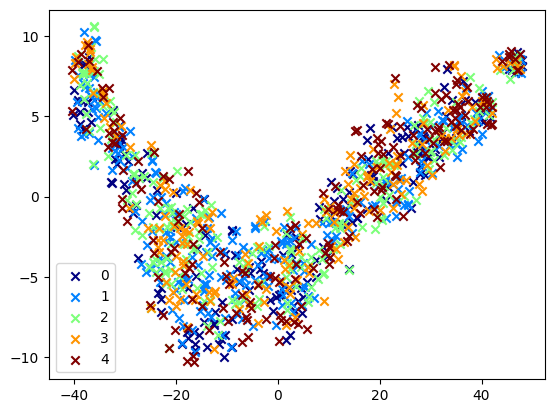

In [40]:
plot_embeddings(embeddings_2d, class_labels)


In [32]:
!pip -q install umap-learn

In [33]:
# Visualize embeddings using UMAP
import umap

reducer = umap.UMAP()
embeddings_2d = reducer.fit_transform(embeddings)
print(embeddings_2d.shape)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(1000, 2)


<ipython-input-30-b61a78bec0e0>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embeddings[mask, 0], embeddings[mask, 1], c=colors[i], label=str(c), marker=marker)


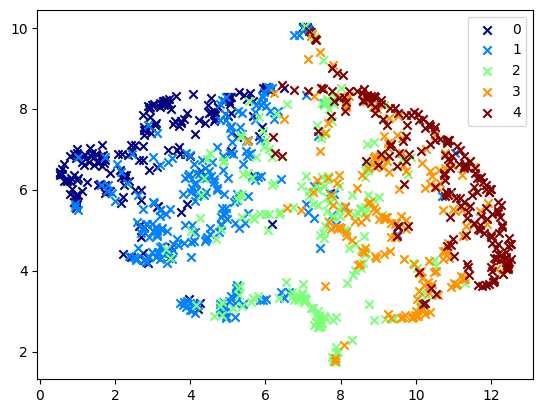

In [34]:
plot_embeddings(embeddings_2d, class_labels)

Porównajmy wizualizacje reprezentacji recenzji wygenerowane przez bazowy, nie dostrojony model.

In [35]:
random_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random_model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [36]:
embeddings, class_labels = compute_embeddings(dataset, random_model, device)
print(embeddings.shape)

100%|██████████| 1000/1000 [00:17<00:00, 57.43it/s]

(1000, 768)


<ipython-input-30-b61a78bec0e0>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embeddings[mask, 0], embeddings[mask, 1], c=colors[i], label=str(c), marker=marker)


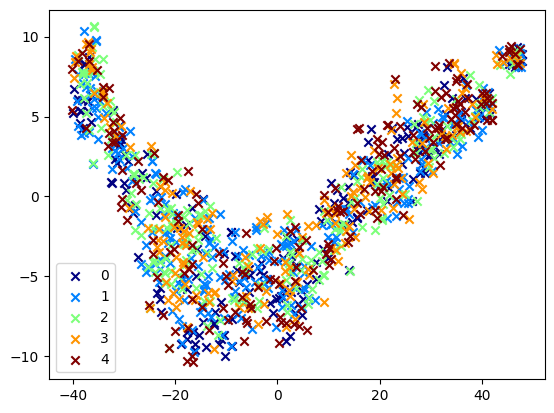

In [37]:
tsne = TSNE(n_components=2, perplexity=50)
embeddings_2d = tsne.fit_transform(embeddings)
plot_embeddings(embeddings_2d, class_labels)

#6. Inne zastosowania
Podejście podobne do przedstawionego w niniejszym notatniku można zastosować do innych zadań związanych z klasyfikacją zdań (zarówno pojedyczych zdań jak i par zdań), takich jak:


*   Czy podane zdanie jest poprawne gramatycznie?
*   Czy podane dwa zdania są logicznie powiązane? (*logical entailment*)
*   Czy jedno ze zdań jest parafrazą drugiego?
*   Czy drugie zdanie zawiera odpowiedź na pytanie zadanie w pierwszym zdaniu?
*   Czy dwa zdania są semantycznie równoważne?
*   Czy poprawne zdanie ma pozytywny czy negatywny wydźwięk? (analiza sentymentu)
*   Ocena semantycznego podobieństwa dwóch zdań w skali od jednego do pięciu.

Więcej informacji i przykłady kodu znajdziesz [tutaj](https://github.com/huggingface/transformers/tree/main/examples/pytorch) i [tutaj](https://github.com/huggingface/notebooks/blob/master/examples/text_classification.ipynb).